<a href="https://colab.research.google.com/github/SaraAsgharQ/Improved-Stock-Price-Prediction/blob/main/AAI_Final_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages (assuming you need them in Colab/Jupyter)
!pip install yfinance pandas-ta scikit-learn tensorflow xgboost

**Data Fetching**

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from datetime import datetime

# Settings matching the paper [cite: 94]
TICKER = "^KSE"
START_DATE = "2010-01-01"
END_DATE = "2025-10-31"

print(f"Fetching data for {TICKER}...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Flatten MultiIndex columns if they exist (common issue with new yfinance)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
# Handle zero volume rows which can break some indicators
data['Volume'] = data['Volume'].replace(0, np.nan).ffill()

print(f"Data fetched. Shape: {data.shape}")

# Display the first 5 rows of the full dataset with features
print("--- Data Snapshot (First 5 Rows) ---")
print(data.head())

# Display the data types and non-null counts to check for errors
print("\n--- Data Info ---")
print(data.info())

# Show summary statistics (Mean, Min, Max) for all features
print("\n--- Statistical Summary ---")
print(data.describe())

Fetching data for ^KSE...


/tmp/ipython-input-1065291834.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Data fetched. Shape: (2809, 5)
--- Data Snapshot (First 5 Rows) ---
Price              Open         High          Low        Close  Volume
Date                                                                  
2010-01-04  9411.750000  9447.290039  9371.280273  9437.849609     NaN
2010-01-05  9462.740234  9664.280273  9462.740234  9657.379883     NaN
2010-01-06  9698.019531  9809.190430  9698.019531  9727.360352     NaN
2010-01-07  9726.730469  9813.129883  9712.240234  9737.469727     NaN
2010-01-08  9752.660156  9823.740234  9735.240234  9776.209961     NaN

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2809 entries, 2010-01-04 to 2021-09-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2809 non-null   float64
 1   High    2809 non-null   float64
 2   Low     2809 non-null   float64
 3   Close   2809 non-null   float64
 4   Volume  2762 non-null   float64
dtypes: float64(5)
memory usage: 

**Feature Engineering**

In [3]:
# Create a copy to avoid SettingWithCopy warnings
df = data.copy()

# --- 1. Moving Averages & Disparity ---
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA14'] = df['Close'].rolling(window=14).mean()

# Disparity 5 & 14: (Close / Moving Average) * 100
df['Disparity_5'] = (df['Close'] / df['MA5']) * 100
df['Disparity_14'] = (df['Close'] / df['MA14']) * 100

# Price Oscillator (OSCP): MA5 - MA10
df['OSCP'] = df['MA5'] - df['MA10']

# Exponential & Weighted Moving Averages
df['EMA'] = ta.ema(df['Close'], length=14)
df['WMA'] = ta.wma(df['Close'], length=14)

# --- 2. Momentum Indicators ---
# Momentum: Close - Close_4 (Paper specific formula)
df['Momentum'] = df['Close'].diff(4)

# ROC: ((Current - Previous_n)/Previous_n) * 100
df['ROC'] = ta.roc(df['Close'], length=10)

# RSI
df['RSI'] = ta.rsi(df['Close'], length=14)

# Williams %R
df['%R'] = ta.willr(df['High'], df['Low'], df['Close'], length=14)

# Stochastic Oscillator (%K, %D)
# Returns DataFrame, so we dynamically find the K and D columns
stoch = ta.stoch(df['High'], df['Low'], df['Close'])
k_col = [c for c in stoch.columns if c.startswith('STOCHk')][0]
d_col = [c for c in stoch.columns if c.startswith('STOCHd')][0]
df['%K'] = stoch[k_col]
df['%D'] = stoch[d_col]

# CCI
df['CCI'] = ta.cci(df['High'], df['Low'], df['Close'], length=14)

# --- 3. Volatility & Trend ---
# Bollinger Bands (Upper and Lower)
# Returns DataFrame, dynamically find Upper (BBU) and Lower (BBL) columns
bbands = ta.bbands(df['Close'], length=20)
bbu_col = [c for c in bbands.columns if c.startswith('BBU')][0]
bbl_col = [c for c in bbands.columns if c.startswith('BBL')][0]
df['Upper_Band'] = bbands[bbu_col]
df['Lower_Band'] = bbands[bbl_col]

# MACD & Signal Line
# Returns DataFrame, dynamically find MACD and Signal columns
macd = ta.macd(df['Close'])
macd_col = [c for c in macd.columns if c.startswith('MACD_')][0]
signal_col = [c for c in macd.columns if c.startswith('MACDs')][0]
df['MACD'] = macd[macd_col]
df['Signal_Line'] = macd[signal_col]

# ATR
df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

# --- 4. Volume Indicators ---
# OBV
df['OBV'] = ta.obv(df['Close'], df['Volume'])

# Chaikin Oscillator
df['Chaikin_Oscillator'] = ta.adosc(df['High'], df['Low'], df['Close'], df['Volume'], open_=df['Open'])

# Money Flow Index (MFI)
df['MFI'] = ta.mfi(df['High'], df['Low'], df['Close'], df['Volume'], length=14)

# --- 5. Pivot Points (Manual Calc based on Paper) ---
# The paper calculates Pivot Points based on the *current* day to predict trend
# Formula: PP = (High + Low + Close) / 3
df['PP'] = (df['High'] + df['Low'] + df['Close']) / 3
df['S1'] = (df['PP'] * 2) - df['High']
df['S2'] = df['PP'] - (df['High'] - df['Low'])
df['R1'] = (df['PP'] * 2) - df['Low']
df['R2'] = df['PP'] + (df['High'] - df['Low'])

# --- 6. Anomalies ---
# Day of Week Anomaly: Close / Mean of Close for that Day of Week
day_means = df.groupby(df.index.dayofweek)['Close'].transform('mean')
df['Day_of_Week_Anomaly'] = df['Close'] / day_means

# Week of Month Anomaly
# Calculate week number within the month (approximate)
df['Week_Num'] = df.index.day.map(lambda x: (x - 1) // 7 + 1)
week_means = df.groupby('Week_Num')['Close'].transform('mean')
df['Week_of_Month_Anomaly'] = df['Close'] / week_means

# --- Target Creation ---
# Target: 1 if Next Day Close > Current Close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop NaN values created by rolling windows and indicators
df_clean = df.dropna()

# Select exactly the features mentioned in the paper + Target
features = ['EMA', 'WMA', 'Disparity_5', 'Disparity_14', 'OSCP',
            'Momentum', 'ROC', 'RSI', '%R', '%K', '%D', 'CCI',
            'Upper_Band', 'Lower_Band', 'MACD', 'Signal_Line', 'ATR',
            'OBV', 'Chaikin_Oscillator', 'MFI',
            'PP', 'S1', 'S2', 'R1', 'R2',
            'Day_of_Week_Anomaly', 'Week_of_Month_Anomaly']

X = df_clean[features]
y = df_clean['Target']

print(f"Feature Engineering Complete. X shape: {X.shape}")
print("Columns:", X.columns.tolist())

Feature Engineering Complete. X shape: (2749, 27)
Columns: ['EMA', 'WMA', 'Disparity_5', 'Disparity_14', 'OSCP', 'Momentum', 'ROC', 'RSI', '%R', '%K', '%D', 'CCI', 'Upper_Band', 'Lower_Band', 'MACD', 'Signal_Line', 'ATR', 'OBV', 'Chaikin_Oscillator', 'MFI', 'PP', 'S1', 'S2', 'R1', 'R2', 'Day_of_Week_Anomaly', 'Week_of_Month_Anomaly']


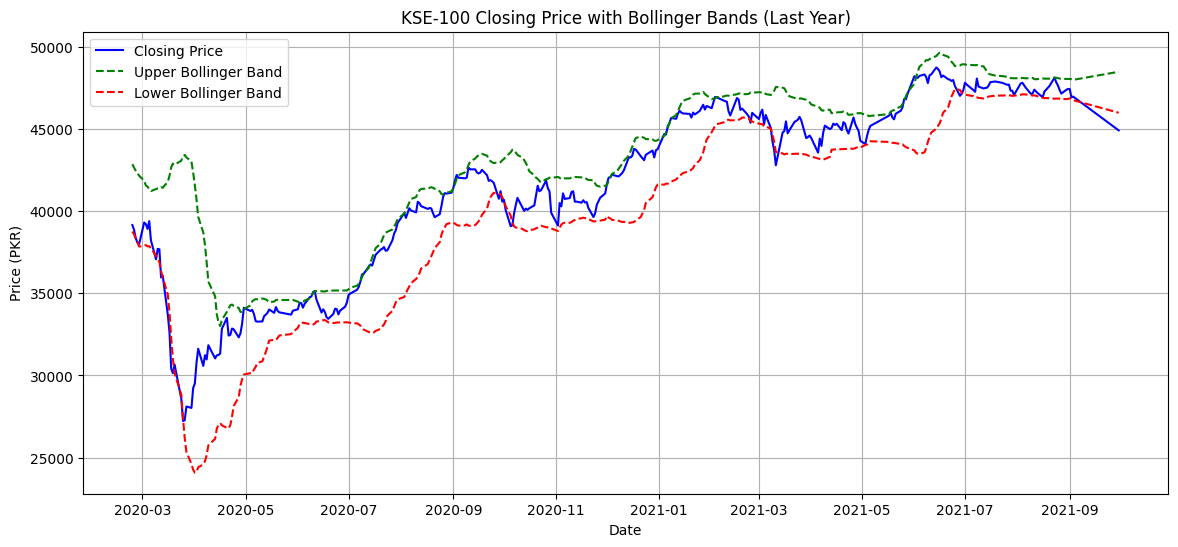

In [4]:
import matplotlib.pyplot as plt

# Plotting one complex indicator for visualization
plt.figure(figsize=(14, 6))
plt.plot(df_clean['Close'].tail(365), label='Closing Price', color='blue')
plt.plot(df_clean['Upper_Band'].tail(365), label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(df_clean['Lower_Band'].tail(365), label='Lower Bollinger Band', color='red', linestyle='--')
plt.title('KSE-100 Closing Price with Bollinger Bands (Last Year)')
plt.xlabel('Date')
plt.ylabel('Price (PKR)')
plt.legend()
plt.grid(True)
plt.show()



**Data Splitting and Scaling**




In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split Data 80/20
# Note: For time series, we typically don't shuffle, but the paper implies standard classification split.
# To be safe and respect time, we use shuffle=False.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Scaled (0 to 1 range).")

Data Scaled (0 to 1 range).


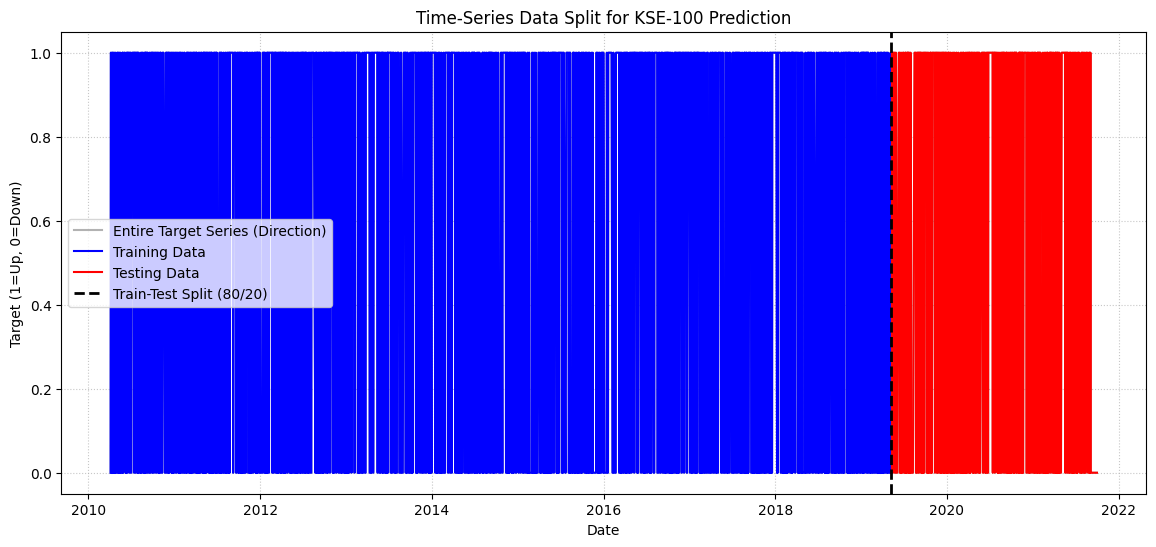

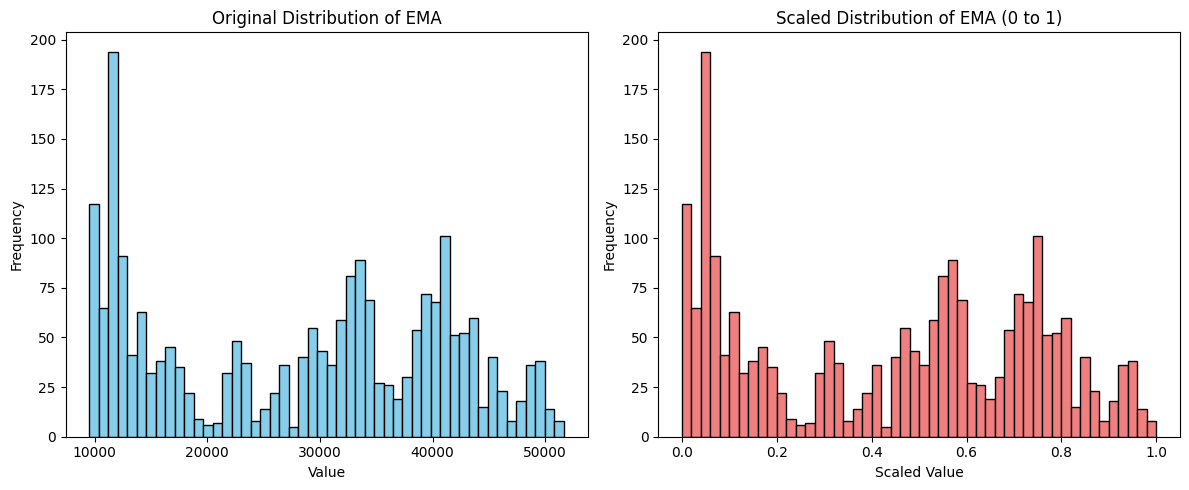

In [6]:

split_index = y_train.index[-1]

plt.figure(figsize=(14, 6))

# Plot the entire target series (y)
plt.plot(y.index, y.values, label='Entire Target Series (Direction)', color='grey', alpha=0.6)

# Highlight the training and testing sections
# The length of X_train gives the number of training samples
train_end_index = X_train.shape[0]

# Plot training data
plt.plot(y.index[:train_end_index], y.values[:train_end_index], label='Training Data', color='blue')
# Plot testing data
plt.plot(y.index[train_end_index:], y.values[train_end_index:], label='Testing Data', color='red')

# Add a vertical line at the split point
plt.axvline(x=split_index, color='black', linestyle='--', linewidth=2, label='Train-Test Split (80/20)')

plt.title('Time-Series Data Split for KSE-100 Prediction')
plt.xlabel('Date')
plt.ylabel('Target (1=Up, 0=Down)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Select the first feature for comparison (e.g., 'EMA')
feature_name = X_train.columns[0]
n_bins = 50

plt.figure(figsize=(12, 5))

# Plot 1: Original Distribution
plt.subplot(1, 2, 1)
plt.hist(X_train[feature_name], bins=n_bins, color='skyblue', edgecolor='black')
plt.title(f'Original Distribution of {feature_name}')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot 2: Scaled Distribution
plt.subplot(1, 2, 2)
plt.hist(X_train_scaled_df[feature_name], bins=n_bins, color='lightcoral', edgecolor='black')
plt.title(f'Scaled Distribution of {feature_name} (0 to 1)')
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Data Scaling with Random Shuffling**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, LayerNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D
from tensorflow.keras import models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM/Transformer [Samples, Timesteps, Features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("Data Split (Random Shuffle) & Scaled.")


Data Split (Random Shuffle) & Scaled.


**ANN Model**

In [8]:
# --- 1. ANN Model ---
print("\n--- Training ANN ---")
ann = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = ann.fit(X_train_scaled, y_train, epochs=50, batch_size=64, verbose=0)

ann_pred = (ann.predict(X_test_scaled) > 0.5).astype(int)

print(f"ANN Accuracy: {accuracy_score(y_test, ann_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, ann_pred))


--- Training ANN ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
ANN Accuracy: 0.5818

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.45      0.50       251
           1       0.60      0.69      0.64       299

    accuracy                           0.58       550
   macro avg       0.58      0.57      0.57       550
weighted avg       0.58      0.58      0.58       550



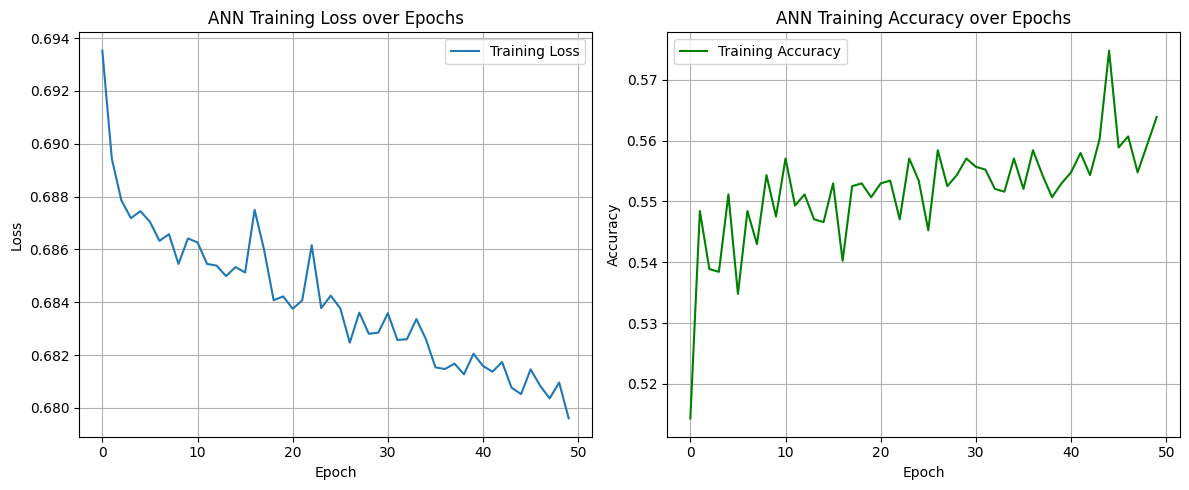

In [9]:
plt.figure(figsize=(12, 5))

# Plot 1: Loss History
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')

plt.title('ANN Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy History
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')

plt.title('ANN Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**SVM Model**

In [10]:
# --- 2. SVM Model ---
print("\n--- Training SVM ---")
svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)

print(f"SVM Accuracy: {accuracy_score(y_test, svm_pred):.4f}")

from sklearn.metrics import classification_report
print("\nSVM Classification Report:\n", classification_report(y_test, svm_pred))


--- Training SVM ---
SVM Accuracy: 0.5600

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.29      0.37       251
           1       0.57      0.79      0.66       299

    accuracy                           0.56       550
   macro avg       0.55      0.54      0.52       550
weighted avg       0.55      0.56      0.53       550



**Random Forest**

In [11]:
# --- 3. Random Forest ---
print("\n--- Training Random Forest ---")
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_pred))


--- Training Random Forest ---
Random Forest Accuracy: 0.5691

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.47      0.50       251
           1       0.59      0.66      0.62       299

    accuracy                           0.57       550
   macro avg       0.56      0.56      0.56       550
weighted avg       0.57      0.57      0.57       550



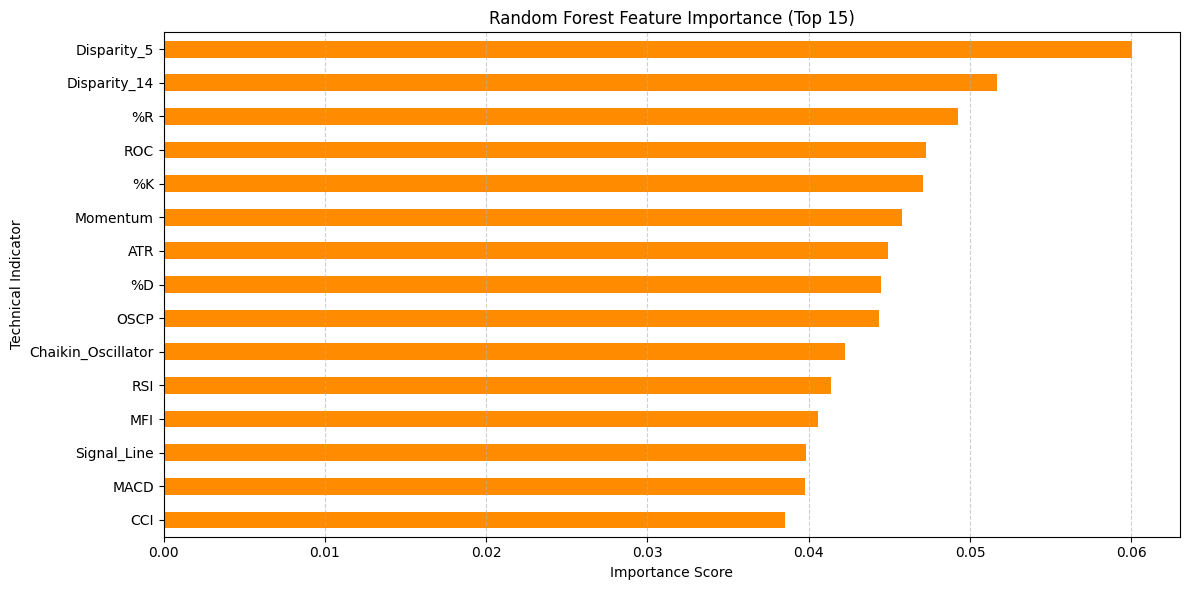

Random Forest Feature Importance visualization generated.


In [12]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
# Get the top 15 features
top_features = feature_importances.nlargest(15)

plt.figure(figsize=(12, 6))
top_features.sort_values(ascending=True).plot(kind='barh', color='darkorange')
plt.title('Random Forest Feature Importance (Top 15)')
plt.xlabel('Importance Score')
plt.ylabel('Technical Indicator')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()

print("Random Forest Feature Importance visualization generated.")

**LSTM**

In [13]:
print("\n--- Training LSTM ---")
lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train_scaled.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=0)
lstm_pred = (lstm.predict(X_test_reshaped) > 0.5).astype(int)

print(f"LSTM Accuracy: {accuracy_score(y_test, lstm_pred):.4f}")

print("\nLSTM Classification Report:\n", classification_report(y_test, lstm_pred))


--- Training LSTM ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
LSTM Accuracy: 0.5691

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.29      0.38       251
           1       0.57      0.81      0.67       299

    accuracy                           0.57       550
   macro avg       0.56      0.55      0.52       550
weighted avg       0.56      0.57      0.54       550



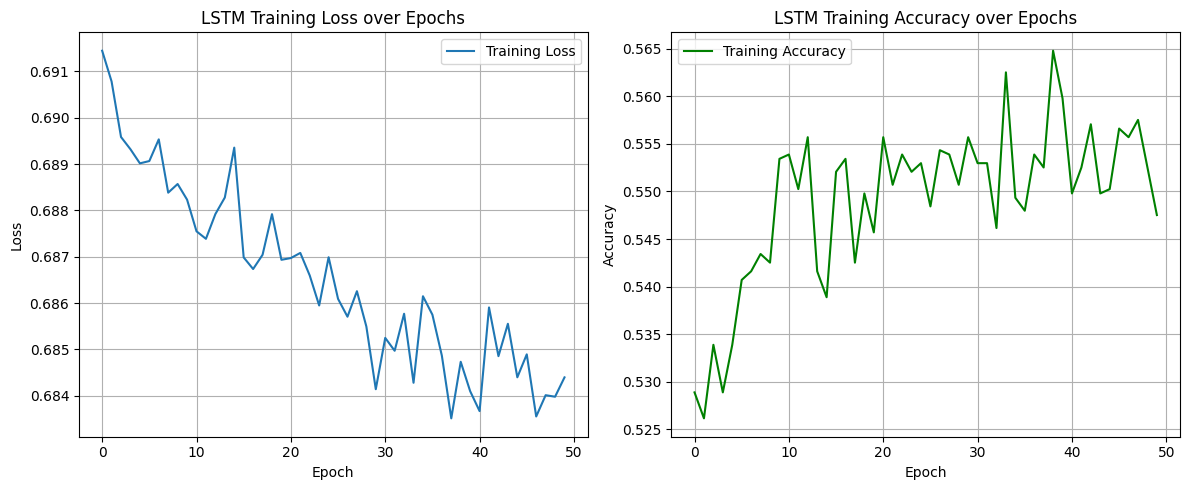

In [14]:
plt.figure(figsize=(12, 5))

# Plot 1: Loss History
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.title('LSTM Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy History
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy', color='green')
plt.title('LSTM Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**XGBoost**

In [15]:
# --- 5. XGBoost ---
print("\n--- Training XGBoost Classifier ---")

xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)
xgb_pred = xgb.predict(X_test_scaled)

print(f"XGBoost Classifier Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")

print("\nXGBoost Classification Report:\n", classification_report(y_test, xgb_pred))


--- Training XGBoost Classifier ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:15:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier Accuracy: 0.5455

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.49      0.50       251
           1       0.58      0.59      0.58       299

    accuracy                           0.55       550
   macro avg       0.54      0.54      0.54       550
weighted avg       0.54      0.55      0.55       550



**Transformer**

In [16]:
# --- 6. Transformer ---
print("\n--- Training Transformer ---")
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

inputs = Input(shape=(1, X_train_scaled.shape[1]))
x = inputs
# Transformer Block
x = transformer_encoder(x, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

model_trans = models.Model(inputs, outputs)
model_trans.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

history_trans = model_trans.fit(X_train_reshaped, y_train, epochs=50, batch_size=64, verbose=0)
trans_pred = (model_trans.predict(X_test_reshaped) > 0.5).astype(int)

print(f"Transformer Accuracy: {accuracy_score(y_test, trans_pred):.4f}")

print("\nTransformer Classification Report:\n", classification_report(y_test, trans_pred))


--- Training Transformer ---


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Transformer Accuracy: 0.5745

Transformer Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.47      0.50       251
           1       0.60      0.67      0.63       299

    accuracy                           0.57       550
   macro avg       0.57      0.57      0.56       550
weighted avg       0.57      0.57      0.57       550



**Improved Accuracy**

In [18]:
# Target_Leaky: 1 if Current Close > Previous Close, else 0
df_clean['Target_Leaky'] = (df_clean['Close'] > df_clean['Close'].shift(1)).astype(int)
df_leaky = df_clean.dropna()

X_leaky = df_leaky[features]
y_leaky = df_leaky['Target_Leaky']

# --- Leaky Scaling (Global Scaling before Split) ---
# This introduces a second form of data leakage by having test set statistics
# influence the scaling factors applied to the training set.
scaler_leaky = MinMaxScaler()
X_leaky_scaled = scaler_leaky.fit_transform(X_leaky)

# --- Random Split (shuffle=True) ---
# A random split is inappropriate for time series but is common in flawed papers.
X_train_leaky, X_test_leaky, y_train_leaky, y_test_leaky = train_test_split(X_leaky_scaled, y_leaky, test_size=0.2, shuffle=True, random_state=42)

# Reshape for LSTM/Transformer [Samples, Timesteps, Features]
X_train_reshaped_leaky = X_train_leaky.reshape((X_train_leaky.shape[0], 1, X_train_leaky.shape[1]))
X_test_reshaped_leaky = X_test_leaky.reshape((X_test_leaky.shape[0], 1, X_test_leaky.shape[1]))

print(f"Data Prepared. Train Shape: {X_train_leaky.shape}, Test Shape: {X_test_leaky.shape}")

Data Prepared. Train Shape: (2199, 27), Test Shape: (550, 27)


In [19]:
# --- 1. ANN Model (Leaky Target) ---
print("\n--- Training ANN (Leaky) ---")
ann_leaky = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_leaky.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
ann_leaky.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_leaky.fit(X_train_leaky, y_train_leaky, epochs=50, batch_size=64, verbose=0)
ann_pred_leaky = (ann_leaky.predict(X_test_leaky) > 0.5).astype(int)
print(f"ANN (Leaky) Accuracy: {accuracy_score(y_test_leaky, ann_pred_leaky):.4f}")

# --- 2. SVM Model (Leaky Target) ---
print("\n--- Training SVM (Leaky) ---")
svm_leaky = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_leaky.fit(X_train_leaky, y_train_leaky)
svm_pred_leaky = svm_leaky.predict(X_test_leaky)
print(f"SVM (Leaky) Accuracy: {accuracy_score(y_test_leaky, svm_pred_leaky):.4f}")

# --- 3. Random Forest (Leaky Target) ---
print("\n--- Training Random Forest (Leaky) ---")
rf_leaky = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_leaky.fit(X_train_leaky, y_train_leaky)
rf_pred_leaky = rf_leaky.predict(X_test_leaky)
print(f"Random Forest (Leaky) Accuracy: {accuracy_score(y_test_leaky, rf_pred_leaky):.4f}")

# --- 4. LSTM (Leaky Target) ---
print("\n--- Training LSTM (Leaky) ---")
# Use the reshaped data: X_train_reshaped_leaky, X_test_reshaped_leaky
lstm_leaky = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train_leaky.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
lstm_leaky.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_leaky.fit(X_train_reshaped_leaky, y_train_leaky, epochs=50, batch_size=32, verbose=0)
lstm_pred_leaky = (lstm_leaky.predict(X_test_reshaped_leaky) > 0.5).astype(int)
print(f"LSTM (Leaky) Accuracy: {accuracy_score(y_test_leaky, lstm_pred_leaky):.4f}")

# --- 5. XGBoost (Leaky Target) ---
print("\n--- Training XGBoost (Leaky) ---")
xgb_leaky = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, use_label_encoder=False, eval_metric='logloss')
xgb_leaky.fit(X_train_leaky, y_train_leaky)
xgb_pred_leaky = xgb_leaky.predict(X_test_leaky)
print(f"XGBoost (Leaky) Accuracy: {accuracy_score(y_test_leaky, xgb_pred_leaky):.4f}")

# --- 6. Transformer (Leaky Target) ---
print("\n--- Training Transformer (Leaky) ---")

# Re-use the transformer_encoder function definition from your previous cells
# Ensure the function is defined or re-run the cell where it was defined.
# For completeness, I'll include the definition here (assuming it was available in the notebook session)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# Build the model using the leaky reshaped data
inputs_leaky = Input(shape=(1, X_train_leaky.shape[1]))
x_leaky = inputs_leaky
# Transformer Block
x_leaky = transformer_encoder(x_leaky, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x_leaky = GlobalAveragePooling1D()(x_leaky)
x_leaky = Dropout(0.1)(x_leaky)
x_leaky = Dense(64, activation="relu")(x_leaky)
x_leaky = Dropout(0.1)(x_leaky)
outputs_leaky = Dense(1, activation="sigmoid")(x_leaky)

model_trans_leaky = models.Model(inputs_leaky, outputs_leaky)
model_trans_leaky.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model_trans_leaky.fit(X_train_reshaped_leaky, y_train_leaky, epochs=50, batch_size=64, verbose=0)
trans_pred_leaky = (model_trans_leaky.predict(X_test_reshaped_leaky) > 0.5).astype(int)
print(f"Transformer (Leaky) Accuracy: {accuracy_score(y_test_leaky, trans_pred_leaky):.4f}")


--- Training ANN (Leaky) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
ANN (Leaky) Accuracy: 0.8182

--- Training SVM (Leaky) ---
SVM (Leaky) Accuracy: 0.7909

--- Training Random Forest (Leaky) ---
Random Forest (Leaky) Accuracy: 0.8018

--- Training LSTM (Leaky) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
LSTM (Leaky) Accuracy: 0.8200

--- Training XGBoost (Leaky) ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:18:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (Leaky) Accuracy: 0.8473

--- Training Transformer (Leaky) ---


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


 1/18 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Transformer (Leaky) Accuracy: 0.8564
